In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import copy
from functools import partial

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
from metal.mmtl.metal_model import MetalModel
from metal.mmtl.slicing.slice_model import SliceModel, SliceRepModel
from metal.mmtl.slicing.moe_model import MoEModel

from metal.mmtl.trainer import MultitaskTrainer
from metal.mmtl.slicing.synthetics.mmtl_utils import create_tasks, create_payloads, train_slice_experts
from metal.mmtl.slicing.synthetics.data_generator import generate_data, get_circle_mask
from metal.mmtl.slicing.synthetics.viz import visualize_payload, visualize_predictions, visualize_attention, score_and_visualize

In [5]:
from metal.utils import set_seed

seed = 444
set_seed(seed)

### Generate Synthetic Dataset
We aim to build a dataset with a linear decision boundary and an abnormal boundary around $x=0.25, y=0$.
We define this slice as our `critical_region`.

In [6]:
from functools import partial
flip_1 = partial(get_circle_mask, center=(0.25, 0), radius=0.2)
flip_2 = partial(get_circle_mask, center=(-0.3, -0.5), radius=0.15)

label_flips = {
    flip_1: 1,
    flip_2: 2
}
uid_lists, Xs, Ys = generate_data(N=5000, label_flips=label_flips)
task_name = "test_task"

#### Generate eval payload over the `critical_slice`

In [7]:
# targets all the data -- used to add the BASE labelset to payloads
identity_fn = lambda x: np.ones(x.shape[0], dtype=np.bool)
# NOTE: the slice function _imperfectly_ targets the critical slice area.
slice_1 = partial(get_circle_mask, center=(0.35, -0.1), radius=0.2)
slice_2 = partial(get_circle_mask, center=(-0.35, -0.4), radius=0.15)

remainder = lambda X: np.logical_not(np.logical_or(slice_1(X), slice_2(X)))

In [8]:
eval_payload = create_payloads(task_name, uid_lists, Xs, Ys, batch_size=1000, 
   slice_funcs={"slice_1": slice_1, "slice_2": slice_2, "remainder": remainder}
#    slice_funcs={"slice_1": flip_1, "slice_2": flip_2}
)[2] # take test set

Vizualizing labelset_gold from payload_test


/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


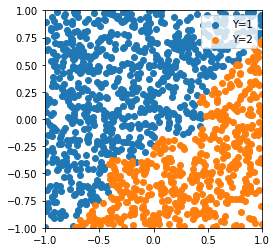

Vizualizing labelset:slice_1:pred from payload_test


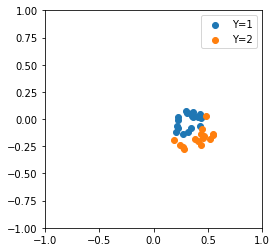

Vizualizing labelset:slice_1:ind from payload_test


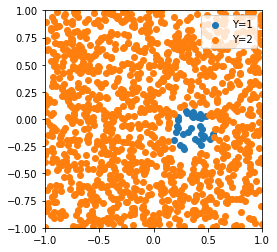

Vizualizing labelset:slice_2:pred from payload_test


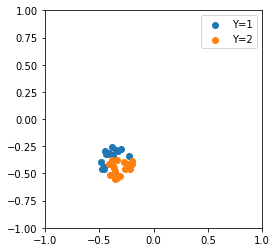

Vizualizing labelset:slice_2:ind from payload_test


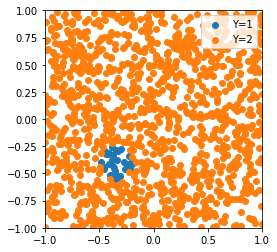

Vizualizing labelset:remainder:pred from payload_test


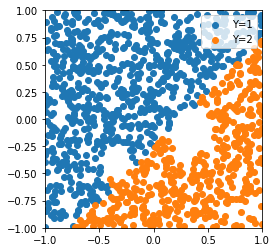

Vizualizing labelset:remainder:ind from payload_test


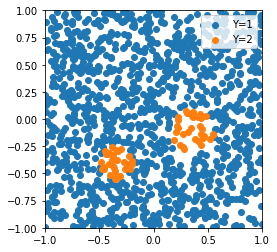

In [9]:
visualize_payload(eval_payload)

### Initialize and train each model type

In [10]:
# all models to test to test
all_slice_funcs = {"slice_1": slice_1, "slice_2": slice_2, "BASE": identity_fn}
slice_loss_multiplier = 1.0 / (2*len(all_slice_funcs))

model_configs = {
    'soft_param': {
        'slice_funcs': all_slice_funcs,
        'create_ind': True,
        'model_class': SliceModel,
        'slice_weights': {
            'BASE': slice_loss_multiplier,
            'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
        }
    },   
    'soft_param_rep': {
        'slice_funcs': all_slice_funcs,
        'create_ind': True,
        'create_preds': False,
        'model_class': SliceRepModel,
        'slice_weights': {
            'BASE': slice_loss_multiplier,
            'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
        },
        'h_dim': 2
    },
    'hard_param': {
        'slice_funcs': all_slice_funcs,
        'create_ind': False,
        'model_class': MetalModel,
        'slice_weights': {'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier}
    },
    'manual_reweighting': {
        'slice_funcs': all_slice_funcs,
        'create_ind': False,
        'slice_weights': {"slice_1": 50}, # 10x weight of slice_2, everythign else default
        'model_class': MetalModel        
    },
    'moe': {
        'slice_funcs': {},
        'create_ind': False,
        'model_class': MoEModel
    },
    'naive': {
        'slice_funcs': {},
        'model_class': MetalModel   
    }
}

In [11]:
train_kwargs = {
    "lr": 0.01, 
    "n_epochs": 600,
    "checkpoint_best": False,
    "log_every": 5.0,
    "writer": "tensorboard", 
    "verbose": True,
    "progress_bar": False
}

==========Initializing + Training soft_param==========
Creating 7 tasks...
BinaryClassificationTask(name=test_task, loss_multiplier=1.00, slice_head_type=None)
BinaryClassificationTask(name=test_task:slice_1:pred, loss_multiplier=0.17, slice_head_type=pred)
BinaryClassificationTask(name=test_task:slice_1:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task:slice_2:pred, loss_multiplier=0.17, slice_head_type=pred)
BinaryClassificationTask(name=test_task:slice_2:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task:BASE:pred, loss_multiplier=0.17, slice_head_type=pred)
BinaryClassificationTask(name=test_task:BASE:ind, loss_multiplier=0.17, slice_head_type=ind)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:slice_1:pred': 'test_task:slice_1:pred', 'labelset:slice_1:ind': 'test_task:slice_1:ind', 'labelset:slice_2:pred': 'test_task:slice_2:pred', 'labelset:slice_2:i

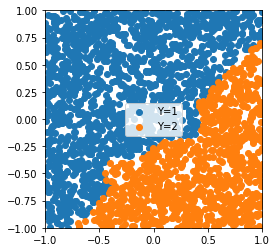

Vizualizing labelset:slice_1:pred from payload_train


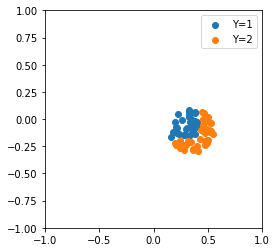

Vizualizing labelset:slice_1:ind from payload_train


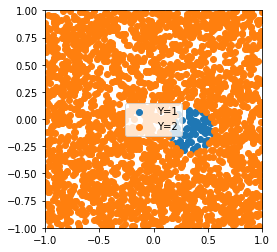

Vizualizing labelset:slice_2:pred from payload_train


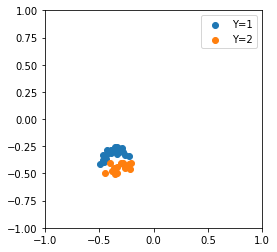

Vizualizing labelset:slice_2:ind from payload_train


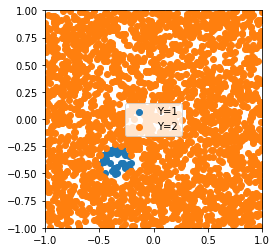

Vizualizing labelset:BASE:pred from payload_train


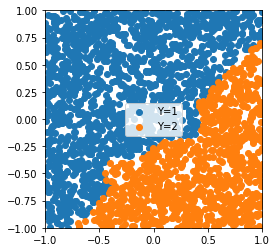

Vizualizing labelset:BASE:ind from payload_train


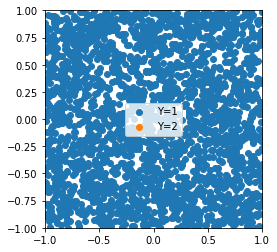

No cuda device available. Using cpu instead.

Network architecture:
SliceModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:ind): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_1:ind): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_1:pred): 

[25.0 epo]: test_task:[payload_train/labelset_gold/loss=8.23e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.34e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.10e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.36e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=8.09e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.40e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.96e-02, payload_valid/labelset:slice_2:pred/accuracy=8.93e-01] model:[train/all/loss=2.43e-02, train/all/lr=1.00e-02, valid/all/loss=2.52e-02]
[30.0 epo]: test_task:[payload_train/labelset_gold/los

[70.0 epo]: test_task:[payload_train/labelset_gold/loss=4.10e-02, payload_valid/labelset_gold/accuracy=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.91e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.53e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.04e-03, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.89e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.75e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.41e-02, train/all/lr=1.00e-02, valid/all/loss=1.65e-02]
[75.0 epo]: test_task:[payload_train/labelset_gold/los

[115.0 epo]: test_task:[payload_train/labelset_gold/loss=4.17e-02, payload_valid/labelset_gold/accuracy=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.68e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.41e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.23e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.84e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.55e-02, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.29e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.31e-02, train/all/lr=1.00e-02, valid/all/loss=1.67e-02]
[120.0 epo]: test_task:[payload_train/labelset_gold/l

[160.0 epo]: test_task:[payload_train/labelset_gold/loss=4.15e-02, payload_valid/labelset_gold/accuracy=9.84e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.36e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=5.77e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.18e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.12e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.88e-02, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=7.69e-03, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.26e-02, train/all/lr=1.00e-02, valid/all/loss=1.64e-02]
[165.0 epo]: test_task:[payload_train/labelset_gold/l

[205.0 epo]: test_task:[payload_train/labelset_gold/loss=4.00e-02, payload_valid/labelset_gold/accuracy=9.84e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.34e-03, payload_valid/labelset:slice_1:ind/accuracy=9.89e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=5.26e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.14e-02, payload_valid/labelset:BASE:pred/accuracy=9.76e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.10e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.55e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=7.17e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.21e-02, train/all/lr=1.00e-02, valid/all/loss=1.60e-02]
[210.0 epo]: test_task:[payload_train/labelset_gold/l

[250.0 epo]: test_task:[payload_train/labelset_gold/loss=3.97e-02, payload_valid/labelset_gold/accuracy=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.30e-03, payload_valid/labelset:slice_1:ind/accuracy=9.89e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.82e-03, payload_valid/labelset:slice_2:ind/accuracy=9.84e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.11e-02, payload_valid/labelset:BASE:pred/accuracy=9.76e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.65e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.38e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.01e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.18e-02, train/all/lr=1.00e-02, valid/all/loss=1.60e-02]
[255.0 epo]: test_task:[payload_train/labelset_gold/l

[295.0 epo]: test_task:[payload_train/labelset_gold/loss=4.00e-02, payload_valid/labelset_gold/accuracy=9.84e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.28e-03, payload_valid/labelset:slice_1:ind/accuracy=9.89e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.35e-03, payload_valid/labelset:slice_2:ind/accuracy=9.89e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.09e-02, payload_valid/labelset:BASE:pred/accuracy=9.77e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.33e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.29e-02, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.00e-03, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.17e-02, train/all/lr=1.00e-02, valid/all/loss=1.58e-02]
[300.0 epo]: test_task:[payload_train/labelset_gold/l

[340.0 epo]: test_task:[payload_train/labelset_gold/loss=4.04e-02, payload_valid/labelset_gold/accuracy=9.83e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.32e-03, payload_valid/labelset:slice_1:ind/accuracy=9.89e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.99e-03, payload_valid/labelset:slice_2:ind/accuracy=9.90e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.07e-02, payload_valid/labelset:BASE:pred/accuracy=9.77e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.39e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.23e-02, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.31e-03, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.17e-02, train/all/lr=1.00e-02, valid/all/loss=1.58e-02]
[345.0 epo]: test_task:[payload_train/labelset_gold/l

[385.0 epo]: test_task:[payload_train/labelset_gold/loss=4.08e-02, payload_valid/labelset_gold/accuracy=9.83e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.34e-03, payload_valid/labelset:slice_1:ind/accuracy=9.89e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.76e-03, payload_valid/labelset:slice_2:ind/accuracy=9.88e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.07e-02, payload_valid/labelset:BASE:pred/accuracy=9.77e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.47e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.20e-02, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.28e-03, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.17e-02, train/all/lr=1.00e-02, valid/all/loss=1.59e-02]
[390.0 epo]: test_task:[payload_train/labelset_gold/l

[430.0 epo]: test_task:[payload_train/labelset_gold/loss=4.11e-02, payload_valid/labelset_gold/accuracy=9.83e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.34e-03, payload_valid/labelset:slice_1:ind/accuracy=9.89e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.59e-03, payload_valid/labelset:slice_2:ind/accuracy=9.89e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.06e-02, payload_valid/labelset:BASE:pred/accuracy=9.77e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.41e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.16e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=7.32e-04, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.17e-02, train/all/lr=1.00e-02, valid/all/loss=1.60e-02]
[435.0 epo]: test_task:[payload_train/labelset_gold/l

[475.0 epo]: test_task:[payload_train/labelset_gold/loss=4.15e-02, payload_valid/labelset_gold/accuracy=9.84e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.35e-03, payload_valid/labelset:slice_1:ind/accuracy=9.89e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.43e-03, payload_valid/labelset:slice_2:ind/accuracy=9.91e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.06e-02, payload_valid/labelset:BASE:pred/accuracy=9.77e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.30e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.13e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.73e-04, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.18e-02, train/all/lr=1.00e-02, valid/all/loss=1.60e-02]
[480.0 epo]: test_task:[payload_train/labelset_gold/l

[520.0 epo]: test_task:[payload_train/labelset_gold/loss=4.18e-02, payload_valid/labelset_gold/accuracy=9.84e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.35e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.31e-03, payload_valid/labelset:slice_2:ind/accuracy=9.91e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.06e-02, payload_valid/labelset:BASE:pred/accuracy=9.77e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.20e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.11e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.08e-04, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.18e-02, train/all/lr=1.00e-02, valid/all/loss=1.61e-02]
[525.0 epo]: test_task:[payload_train/labelset_gold/l

[565.0 epo]: test_task:[payload_train/labelset_gold/loss=4.21e-02, payload_valid/labelset_gold/accuracy=9.84e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.36e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.19e-03, payload_valid/labelset:slice_2:ind/accuracy=9.91e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.06e-02, payload_valid/labelset:BASE:pred/accuracy=9.77e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.13e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.09e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.05e-04, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.18e-02, train/all/lr=1.00e-02, valid/all/loss=1.62e-02]
[570.0 epo]: test_task:[payload_train/labelset_gold/l

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:937: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'test_task/payload_test/labelset_gold/accuracy': 0.9784,
 'test_task/payload_train/labelset_gold/accuracy': 0.9908,
 'test_task:BASE:ind/payload_test/labelset:BASE:ind/accuracy': 1.0,
 'test_task:BASE:ind/payload_train/labelset:BASE:ind/accuracy': 1.0,
 'test_task:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.9712,
 'test_task:BASE:pred/payload_train/labelset:BASE:pred/accuracy': 0.978,
 'test_task:slice_1:ind/payload_test/labelset:slice_1:ind/accuracy': 0.9936,
 'test_task:slice_1:ind/payload_train/labelset:slice_1:ind/accuracy': 0.99,
 'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9705882352941176,
 'test_task:slice_1:pred/payload_train/labelset:slice_1:pred/accuracy': 0.974025974025974,
 'test_task:slice_2:ind/payload_test/labelset:slice_2:ind/accuracy': 0.9896,
 'test_task:slice_2:ind/payload_train/labelset:slice_2:ind/accuracy': 0.992,
 'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.90625,
 'test_task:slice_2:pred/payloa

/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


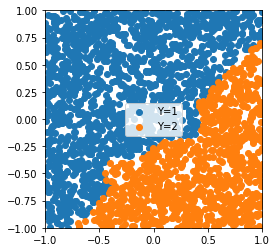

Vizualizing labelset:slice_1:ind from payload_train


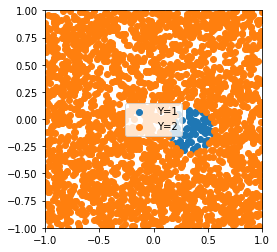

Vizualizing labelset:slice_2:ind from payload_train


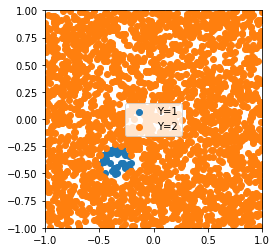

Vizualizing labelset:BASE:ind from payload_train


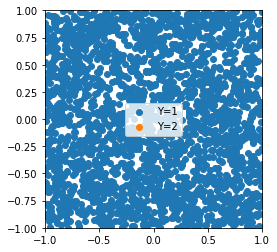

No cuda device available. Using cpu instead.

Network architecture:
SliceRepModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:ind): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_1:ind): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_2:ind): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
  )
  (middle_modules): M

[55.0 epo]: test_task:[payload_train/labelset_gold/loss=7.36e-02, payload_valid/labelset_gold/accuracy=9.77e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.11e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.46e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] model:[train/all/loss=2.46e-02, train/all/lr=1.00e-02, valid/all/loss=2.46e-02]
[60.0 epo]: test_task:[payload_train/labelset_gold/loss=7.34e-02, payload_valid/labelset_gold/accuracy=9.77e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.35e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.09e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.04e-07, p

[130.0 epo]: test_task:[payload_train/labelset_gold/loss=5.44e-02, payload_valid/labelset_gold/accuracy=9.77e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.58e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.15e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.02e-09, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] model:[train/all/loss=1.79e-02, train/all/lr=1.00e-02, valid/all/loss=1.85e-02]
[135.0 epo]: test_task:[payload_train/labelset_gold/loss=5.31e-02, payload_valid/labelset_gold/accuracy=9.77e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.36e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.15e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.14e-09,

[205.0 epo]: test_task:[payload_train/labelset_gold/loss=4.36e-02, payload_valid/labelset_gold/accuracy=9.78e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.55e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.05e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.83e-10, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] model:[train/all/loss=1.44e-02, train/all/lr=1.00e-02, valid/all/loss=1.63e-02]
[210.0 epo]: test_task:[payload_train/labelset_gold/loss=4.18e-02, payload_valid/labelset_gold/accuracy=9.79e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.52e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.03e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.99e-10,

[280.0 epo]: test_task:[payload_train/labelset_gold/loss=3.66e-02, payload_valid/labelset_gold/accuracy=9.79e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.12e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.52e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] model:[train/all/loss=1.26e-02, train/all/lr=1.00e-02, valid/all/loss=1.57e-02]
[285.0 epo]: test_task:[payload_train/labelset_gold/loss=3.65e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.17e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.51e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00,

[355.0 epo]: test_task:[payload_train/labelset_gold/loss=3.50e-02, payload_valid/labelset_gold/accuracy=9.79e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.53e-03, payload_valid/labelset:slice_1:ind/accuracy=9.89e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.27e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] model:[train/all/loss=1.22e-02, train/all/lr=1.00e-02, valid/all/loss=1.66e-02]
[360.0 epo]: test_task:[payload_train/labelset_gold/loss=3.49e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.52e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.25e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00,

[430.0 epo]: test_task:[payload_train/labelset_gold/loss=3.37e-02, payload_valid/labelset_gold/accuracy=9.78e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.95e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.93e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] model:[train/all/loss=1.19e-02, train/all/lr=1.00e-02, valid/all/loss=1.64e-02]
[435.0 epo]: test_task:[payload_train/labelset_gold/loss=3.34e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.00e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.88e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00,

[505.0 epo]: test_task:[payload_train/labelset_gold/loss=3.10e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.54e-03, payload_valid/labelset:slice_1:ind/accuracy=9.87e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.77e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] model:[train/all/loss=1.13e-02, train/all/lr=1.00e-02, valid/all/loss=1.56e-02]
[510.0 epo]: test_task:[payload_train/labelset_gold/loss=3.09e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.50e-03, payload_valid/labelset:slice_1:ind/accuracy=9.88e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.78e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00,

[580.0 epo]: test_task:[payload_train/labelset_gold/loss=3.01e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.21e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.81e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] model:[train/all/loss=1.10e-02, train/all/lr=1.00e-02, valid/all/loss=1.62e-02]
[585.0 epo]: test_task:[payload_train/labelset_gold/loss=3.00e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.20e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.81e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00,

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:937: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'test_task/payload_test/labelset_gold/accuracy': 0.9728,
 'test_task/payload_train/labelset_gold/accuracy': 0.9888,
 'test_task:BASE:ind/payload_test/labelset:BASE:ind/accuracy': 1.0,
 'test_task:BASE:ind/payload_train/labelset:BASE:ind/accuracy': 1.0,
 'test_task:slice_1:ind/payload_test/labelset:slice_1:ind/accuracy': 0.9912,
 'test_task:slice_1:ind/payload_train/labelset:slice_1:ind/accuracy': 0.9872,
 'test_task:slice_2:ind/payload_test/labelset:slice_2:ind/accuracy': 0.9744,
 'test_task:slice_2:ind/payload_train/labelset:slice_2:ind/accuracy': 0.9836}
Cleaning checkpoints
Writing metrics to /Users/vincentchen/code/metal/logs/2019_05_03/19_23_54/metrics.json
Writing log to /Users/vincentchen/code/metal/logs/2019_05_03/19_23_54/log.json
Full model saved at /Users/vincentchen/code/metal/logs/2019_05_03/19_23_54/model.pkl
{'test_task/payload_test/labelset_gold/accuracy': 0.9728, 'test_task:slice_1:ind/payload_test/labelset:slice_1:ind/accuracy': 0.9912, 'test_task:slice_2:ind/payload

/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


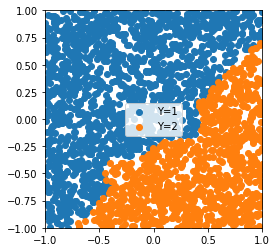

Vizualizing labelset:slice_1:pred from payload_train


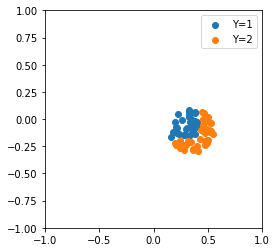

Vizualizing labelset:slice_2:pred from payload_train


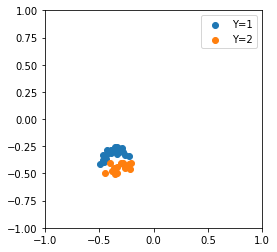

Vizualizing labelset:BASE:pred from payload_train


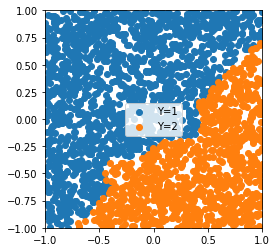

No cuda device available. Using cpu instead.

Network architecture:
MetalModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_1:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_2:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
  )
  (middle_modules): M

[55.0 epo]: test_task:[payload_train/labelset_gold/loss=8.54e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.54e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.32e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.29e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=8.45e-02, train/all/lr=1.00e-02, valid/all/loss=8.35e-02]
[60.0 epo]: test_task:[payload_train/labelset_gold/loss=8.53e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.53e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.32e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/lo

[130.0 epo]: test_task:[payload_train/labelset_gold/loss=8.51e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.51e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.31e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.04e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=8.42e-02, train/all/lr=1.00e-02, valid/all/loss=8.36e-02]
[135.0 epo]: test_task:[payload_train/labelset_gold/loss=8.51e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.51e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.30e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[205.0 epo]: test_task:[payload_train/labelset_gold/loss=8.51e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.51e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.31e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.91e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=8.42e-02, train/all/lr=1.00e-02, valid/all/loss=8.38e-02]
[210.0 epo]: test_task:[payload_train/labelset_gold/loss=8.51e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.51e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.32e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[280.0 epo]: test_task:[payload_train/labelset_gold/loss=8.51e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.51e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.34e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.75e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=8.42e-02, train/all/lr=1.00e-02, valid/all/loss=8.39e-02]
[285.0 epo]: test_task:[payload_train/labelset_gold/loss=8.51e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.51e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.34e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[355.0 epo]: test_task:[payload_train/labelset_gold/loss=8.52e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.52e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.35e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.54e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=8.42e-02, train/all/lr=1.00e-02, valid/all/loss=8.40e-02]
[360.0 epo]: test_task:[payload_train/labelset_gold/loss=8.52e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.52e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.36e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[430.0 epo]: test_task:[payload_train/labelset_gold/loss=8.49e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.49e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.37e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.66e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02, valid/all/loss=8.31e-02]
[435.0 epo]: test_task:[payload_train/labelset_gold/loss=8.49e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.49e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.37e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[505.0 epo]: test_task:[payload_train/labelset_gold/loss=8.45e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.45e-02, payload_valid/labelset:BASE:pred/accuracy=9.75e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.36e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.04e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=8.34e-02, train/all/lr=1.00e-02, valid/all/loss=8.22e-02]
[510.0 epo]: test_task:[payload_train/labelset_gold/loss=8.45e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.45e-02, payload_valid/labelset:BASE:pred/accuracy=9.75e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.37e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[580.0 epo]: test_task:[payload_train/labelset_gold/loss=8.43e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.43e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.37e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=8.74e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=8.32e-02, train/all/lr=1.00e-02, valid/all/loss=8.19e-02]
[585.0 epo]: test_task:[payload_train/labelset_gold/loss=8.43e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.43e-02, payload_valid/labelset:BASE:pred/accuracy=9.75e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.37e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:937: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'test_task/payload_test/labelset_gold/accuracy': 0.9664,
 'test_task/payload_train/labelset_gold/accuracy': 0.97,
 'test_task:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.9664,
 'test_task:BASE:pred/payload_train/labelset:BASE:pred/accuracy': 0.97,
 'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9117647058823529,
 'test_task:slice_1:pred/payload_train/labelset:slice_1:pred/accuracy': 0.8311688311688312,
 'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.84375,
 'test_task:slice_2:pred/payload_train/labelset:slice_2:pred/accuracy': 1.0}
Cleaning checkpoints
Writing metrics to /Users/vincentchen/code/metal/logs/2019_05_03/19_30_39/metrics.json
Writing log to /Users/vincentchen/code/metal/logs/2019_05_03/19_30_39/log.json
Full model saved at /Users/vincentchen/code/metal/logs/2019_05_03/19_30_39/model.pkl
{'test_task/payload_test/labelset_gold/accuracy': 0.9664, 'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 

/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


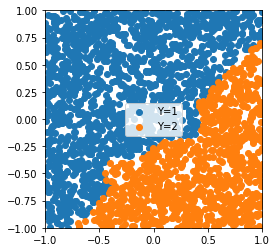

Vizualizing labelset:slice_1:pred from payload_train


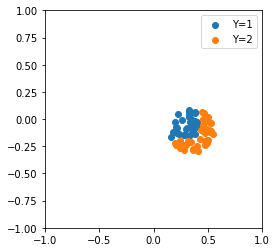

Vizualizing labelset:slice_2:pred from payload_train


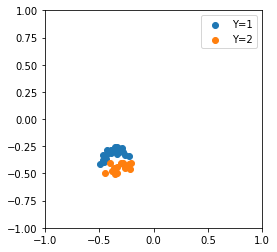

Vizualizing labelset:BASE:pred from payload_train


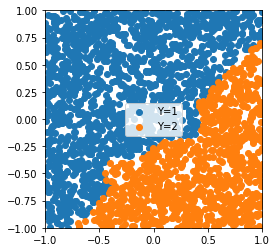

No cuda device available. Using cpu instead.

Network architecture:
MetalModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_1:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_2:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
  )
  (middle_modules): M

[55.0 epo]: test_task:[payload_train/labelset_gold/loss=9.34e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=9.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.72e+01, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.96e-01, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=5.02e-01, train/all/lr=1.00e-02, valid/all/loss=2.35e-01]
[60.0 epo]: test_task:[payload_train/labelset_gold/loss=9.26e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=9.26e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.83e+01, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/lo

[130.0 epo]: test_task:[payload_train/labelset_gold/loss=8.90e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.90e-02, payload_valid/labelset:BASE:pred/accuracy=9.75e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.85e+01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.04e-01, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=6.67e-01, train/all/lr=1.00e-02, valid/all/loss=3.06e-01]
[135.0 epo]: test_task:[payload_train/labelset_gold/loss=8.89e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.75e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.89e+01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[205.0 epo]: test_task:[payload_train/labelset_gold/loss=8.80e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.80e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.24e+01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.27e-01, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=7.26e-01, train/all/lr=1.00e-02, valid/all/loss=3.29e-01]
[210.0 epo]: test_task:[payload_train/labelset_gold/loss=8.80e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.80e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.24e+01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[280.0 epo]: test_task:[payload_train/labelset_gold/loss=8.79e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.79e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.24e+01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.42e-01, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=7.26e-01, train/all/lr=1.00e-02, valid/all/loss=3.22e-01]
[285.0 epo]: test_task:[payload_train/labelset_gold/loss=8.79e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.79e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.24e+01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[355.0 epo]: test_task:[payload_train/labelset_gold/loss=8.79e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.79e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.19e+01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.48e-01, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=7.19e-01, train/all/lr=1.00e-02, valid/all/loss=3.20e-01]
[360.0 epo]: test_task:[payload_train/labelset_gold/loss=8.79e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.79e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.19e+01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[430.0 epo]: test_task:[payload_train/labelset_gold/loss=8.78e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.78e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.18e+01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.46e-01, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=7.16e-01, train/all/lr=1.00e-02, valid/all/loss=3.23e-01]
[435.0 epo]: test_task:[payload_train/labelset_gold/loss=8.78e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.78e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.18e+01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[505.0 epo]: test_task:[payload_train/labelset_gold/loss=8.78e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.78e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.16e+01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.43e-01, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=7.14e-01, train/all/lr=1.00e-02, valid/all/loss=3.20e-01]
[510.0 epo]: test_task:[payload_train/labelset_gold/loss=8.78e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.78e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.16e+01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[580.0 epo]: test_task:[payload_train/labelset_gold/loss=8.77e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.77e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.16e+01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.39e-01, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=7.14e-01, train/all/lr=1.00e-02, valid/all/loss=3.12e-01]
[585.0 epo]: test_task:[payload_train/labelset_gold/loss=8.77e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.77e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.16e+01, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:937: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'test_task/payload_test/labelset_gold/accuracy': 0.9672,
 'test_task/payload_train/labelset_gold/accuracy': 0.9724,
 'test_task:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.9672,
 'test_task:BASE:pred/payload_train/labelset:BASE:pred/accuracy': 0.9724,
 'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9117647058823529,
 'test_task:slice_1:pred/payload_train/labelset:slice_1:pred/accuracy': 0.8571428571428571,
 'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.84375,
 'test_task:slice_2:pred/payload_train/labelset:slice_2:pred/accuracy': 0.9512195121951219}
Cleaning checkpoints
Writing metrics to /Users/vincentchen/code/metal/logs/2019_05_03/19_36_04/metrics.json
Writing log to /Users/vincentchen/code/metal/logs/2019_05_03/19_36_04/log.json
Full model saved at /Users/vincentchen/code/metal/logs/2019_05_03/19_36_04/model.pkl
{'test_task/payload_test/labelset_gold/accuracy': 0.9672, 'test_task:slice_1:pred/payload_test/labelset:slice

/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


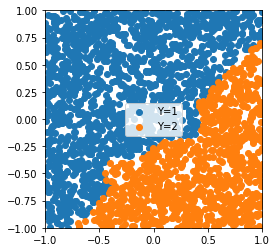

Creating 1 tasks...
BinaryClassificationTask(name=expert:slice_1:pred, loss_multiplier=1.00, slice_head_type=pred)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=train)
Payload(payload_valid: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=valid)
Payload(payload_test: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=test)
[BinaryClassificationTask(name=expert:slice_1:pred, loss_multiplier=1.00, slice_head_type=pred)]
[Payload(payload_train: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=train), Payload(payload_valid: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=valid), Payload(payload_test: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=test)]
No cuda device available. Using cpu instead.

Network architecture:
MetalModel(
  (input_modules): ModuleDict(
    (expert:slice_1:pred): Dat

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:937: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


Beginning train loop.
Expecting a total of approximately 2512 examples and 157 batches per epoch from 1 payload(s) in the train split.
Writing config to /Users/vincentchen/code/metal/logs/2019_05_03/19_41_43/config.json
[5.0 epo]: expert:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.75e-01, payload_valid/labelset:slice_2:pred/accuracy=6.07e-01] model:[train/all/loss=5.75e-01, train/all/lr=1.00e-02, valid/all/loss=5.85e-01]
[10.0 epo]: expert:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.45e-01, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.45e-01, train/all/lr=1.00e-02, valid/all/loss=3.09e-01]
[15.0 epo]: expert:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.16e-01, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.16e-01, train/all/lr=1.00e-02, valid/all/loss=2.94e-01]
[20.0 epo]: expert:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=8.19e-02, payload_valid/labelset:slice_2:pred/accu

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:937: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


Writing config to /Users/vincentchen/code/metal/logs/2019_05_03/19_42_02/config.json
[5.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.59e-01, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] model:[train/all/loss=1.59e-01, train/all/lr=1.00e-02, valid/all/loss=8.55e-02]
[10.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.59e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01] model:[train/all/loss=8.59e-02, train/all/lr=1.00e-02, valid/all/loss=8.48e-02]
[15.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.57e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01] model:[train/all/loss=8.57e-02, train/all/lr=1.00e-02, valid/all/loss=8.48e-02]
[20.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.56e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01] model:[train/all/loss=8.56e-02, train/all/lr=1.00e-02, valid/all/loss=8.48e-02]
[25.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.56e-02

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:937: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'expert:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.9656,
 'expert:BASE:pred/payload_train/labelset:BASE:pred/accuracy': 0.9688}
Cleaning checkpoints
Writing metrics to /Users/vincentchen/code/metal/logs/2019_05_03/19_42_02/metrics.json
Writing log to /Users/vincentchen/code/metal/logs/2019_05_03/19_42_02/log.json
Full model saved at /Users/vincentchen/code/metal/logs/2019_05_03/19_42_02/model.pkl
{'expert:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.9656, 'expert:BASE:pred/payload_train/labelset:BASE:pred/accuracy': 0.9688}
Beginning train loop.
Expecting a total of approximately 2512 examples and 157 batches per epoch from 1 payload(s) in the train split.
Writing config to /Users/vincentchen/code/metal/logs/2019_05_03/19_42_39/config.json
[5.0 epo]: test_task:[payload_train/labelset_gold/loss=2.38e-01, payload_valid/labelset_gold/accuracy=9.48e-01] model:[train/all/loss=2.38e-01, train/all/lr=1.00e-02, valid/all/loss=2.30e-01]
[10.0 epo]: test_task:[payload_trai

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:937: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'test_task/payload_test/labelset_gold/accuracy': 0.9504,
 'test_task/payload_train/labelset_gold/accuracy': 0.9596}
Cleaning checkpoints
Writing metrics to /Users/vincentchen/code/metal/logs/2019_05_03/19_42_39/metrics.json
Writing log to /Users/vincentchen/code/metal/logs/2019_05_03/19_42_39/log.json
Full model saved at /Users/vincentchen/code/metal/logs/2019_05_03/19_42_39/model.pkl
{'test_task/payload_test/labelset_gold/accuracy': 0.9504, 'test_task/payload_train/labelset_gold/accuracy': 0.9596}
==========Initializing + Training naive==========
Creating 1 tasks...
BinaryClassificationTask(name=test_task, loss_multiplier=1.00, slice_head_type=None)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset_gold': 'test_task'}], split=train)
Payload(payload_valid: labels_to_tasks=[{'labelset_gold': 'test_task'}], split=valid)
Payload(payload_test: labels_to_tasks=[{'labelset_gold': 'test_task'}], split=test)
Vizualizing labelset_gold from payload_train


/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


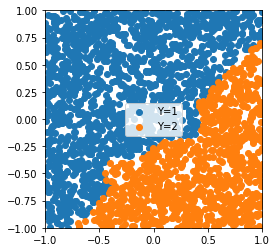

No cuda device available. Using cpu instead.

Network architecture:
MetalModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=5, bias=True)
          (1): ReLU()
        )
      )
    )
  )
  (middle_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
  )
  (attention_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
  )
  (head_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Linear(in_features=5, out_features=1, bias=True)
      )
    )
  )
)

Total number of parameters: 21
Beginning train loop.
Expecting a total of approximately 2512 examples and 157 batches per epoch from 1 payload(s) in the train split.
Writing config to /U

[190.0 epo]: test_task:[payload_train/labelset_gold/loss=8.49e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.49e-02, train/all/lr=1.00e-02, valid/all/loss=8.50e-02]
[195.0 epo]: test_task:[payload_train/labelset_gold/loss=8.49e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.49e-02, train/all/lr=1.00e-02, valid/all/loss=8.50e-02]
[200.0 epo]: test_task:[payload_train/labelset_gold/loss=8.49e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.49e-02, train/all/lr=1.00e-02, valid/all/loss=8.50e-02]
[205.0 epo]: test_task:[payload_train/labelset_gold/loss=8.49e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.49e-02, train/all/lr=1.00e-02, valid/all/loss=8.50e-02]
[210.0 epo]: test_task:[payload_train/labelset_gold/loss=8.49e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.49e-02, train/all/lr=1.00e-02, valid/all/loss=8.50e-02]
[215.0 epo]: test_task:[payloa

[405.0 epo]: test_task:[payload_train/labelset_gold/loss=8.13e-02, payload_valid/labelset_gold/accuracy=9.73e-01] model:[train/all/loss=8.13e-02, train/all/lr=1.00e-02, valid/all/loss=8.58e-02]
[410.0 epo]: test_task:[payload_train/labelset_gold/loss=8.13e-02, payload_valid/labelset_gold/accuracy=9.73e-01] model:[train/all/loss=8.13e-02, train/all/lr=1.00e-02, valid/all/loss=8.58e-02]
[415.0 epo]: test_task:[payload_train/labelset_gold/loss=8.13e-02, payload_valid/labelset_gold/accuracy=9.73e-01] model:[train/all/loss=8.13e-02, train/all/lr=1.00e-02, valid/all/loss=8.58e-02]
[420.0 epo]: test_task:[payload_train/labelset_gold/loss=8.12e-02, payload_valid/labelset_gold/accuracy=9.73e-01] model:[train/all/loss=8.12e-02, train/all/lr=1.00e-02, valid/all/loss=8.58e-02]
[425.0 epo]: test_task:[payload_train/labelset_gold/loss=8.12e-02, payload_valid/labelset_gold/accuracy=9.73e-01] model:[train/all/loss=8.12e-02, train/all/lr=1.00e-02, valid/all/loss=8.58e-02]
[430.0 epo]: test_task:[payloa

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:937: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'test_task/payload_test/labelset_gold/accuracy': 0.9656,
 'test_task/payload_train/labelset_gold/accuracy': 0.9712}
Cleaning checkpoints
Writing metrics to /Users/vincentchen/code/metal/logs/2019_05_03/19_43_30/metrics.json
Writing log to /Users/vincentchen/code/metal/logs/2019_05_03/19_43_30/log.json
Full model saved at /Users/vincentchen/code/metal/logs/2019_05_03/19_43_30/model.pkl
{'test_task/payload_test/labelset_gold/accuracy': 0.9656, 'test_task/payload_train/labelset_gold/accuracy': 0.9712}
CPU times: user 30min 38s, sys: 28.3 s, total: 31min 6s
Wall time: 32min


In [12]:
%%time
trained_models = {}
for model_name, config in model_configs.items():
    print(f"{'='*10}Initializing + Training {model_name}{'='*10}")
    slice_funcs = config['slice_funcs']
    model_class = config['model_class']
    slice_weights = config.get("slice_weights", {})
    create_ind = config.get("create_ind", True)
    create_preds = config.get("create_preds", True)
    h_dim = config.get("h_dim", None)
          
    tasks = create_tasks(
        task_name, 
        slice_names=list(slice_funcs.keys()), 
        slice_weights=slice_weights, 
        create_ind=create_ind,
        create_preds=create_preds,
        h_dim=h_dim,
        verbose=True
    )
    payloads = create_payloads(
        task_name, 
        uid_lists, 
        Xs, 
        Ys,
        batch_size=16, 
        slice_funcs=slice_funcs, 
        create_ind=create_ind,
        create_preds=create_preds,
        verbose=True
    )
    visualize_payload(payloads[0])
          
    if model_name == 'moe':
        # train for same total num epochs
        expert_train_kwargs = copy.deepcopy(train_kwargs)
        expert_train_kwargs['n_epochs'] = int(train_kwargs['n_epochs'] / (len(all_slice_funcs) + 1))
        experts = train_slice_experts(
            uid_lists, Xs, Ys, MetalModel, all_slice_funcs, **expert_train_kwargs
        )
        model = model_class(tasks, experts, verbose=False, seed=seed)
        trainer = MultitaskTrainer(seed=seed)
        metrics_dict = trainer.train_model(model, payloads, **expert_train_kwargs)
    else:
        model = model_class(tasks, h_dim=h_dim, verbose=True, seed=seed)
        trainer = MultitaskTrainer(seed=seed)
        metrics_dict = trainer.train_model(model, payloads, **train_kwargs)
    print(metrics_dict) 
    trained_models[model_name] = model

### Confirm that slice heads are actually experts at their jobs...

labelset 'labelset_gold' -> task 'None' (originally, test_task).
labelset 'labelset:remainder:pred' -> task 'None' (originally, test_task:remainder:pred).
labelset 'labelset:remainder:ind' -> task 'None' (originally, test_task:remainder:ind).
==========Evaluating soft_param==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': None,
    'labelset:slice_1:ind': 'test_task:slice_1:ind',
    'labelset:slice_1:pred': 'test_task:slice_1:pred',
    'labelset:slice_2:ind': 'test_task:slice_2:ind',
    'labelset:slice_2:pred': 'test_task:slice_2:pred',
    'labelset_gold': None}
Model Scores:
{   'test_task:slice_1:ind/payload_test/labelset:slice_1:ind/accuracy': 0.9936,
    'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9705882352941176,
    'test_task:slice_2:ind/payload_test/labelset:slice_2:ind/accuracy': 0.9896,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.90625}
Vizualizing test_task:slice_1:pr

/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


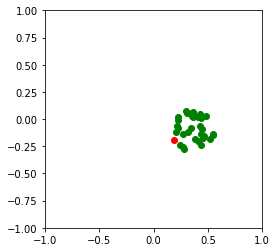

Vizualizing test_task:slice_1:ind predictions on labelset:slice_1:ind


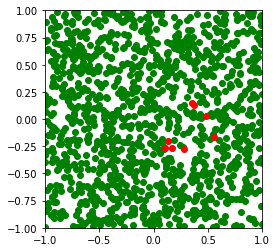

Vizualizing test_task:slice_2:pred predictions on labelset:slice_2:pred


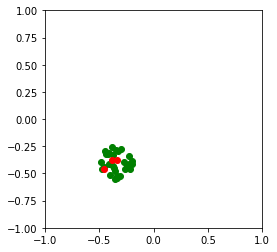

Vizualizing test_task:slice_2:ind predictions on labelset:slice_2:ind


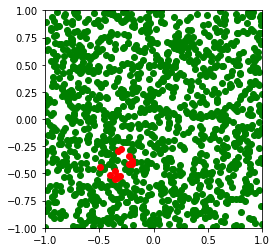

labelset 'labelset:slice_1:ind' -> task 'None' (originally, test_task:slice_1:ind).
labelset 'labelset:slice_2:ind' -> task 'None' (originally, test_task:slice_2:ind).
==========Evaluating hard_param==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': None,
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task:slice_1:pred',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task:slice_2:pred',
    'labelset_gold': None}
Model Scores:
{   'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9117647058823529,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.84375}
Vizualizing test_task:slice_1:pred predictions on labelset:slice_1:pred


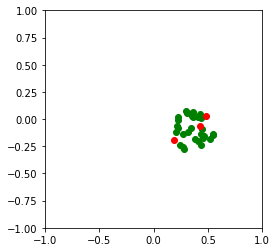

Vizualizing test_task:slice_2:pred predictions on labelset:slice_2:pred


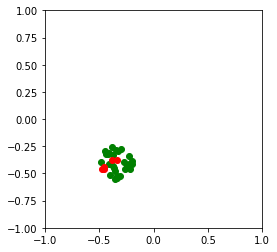

==========Evaluating manual_reweighting==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': None,
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task:slice_1:pred',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task:slice_2:pred',
    'labelset_gold': None}
Model Scores:
{   'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9117647058823529,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.84375}
Vizualizing test_task:slice_1:pred predictions on labelset:slice_1:pred


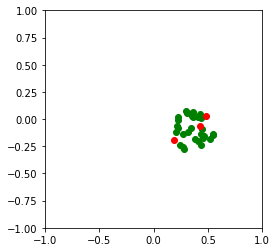

Vizualizing test_task:slice_2:pred predictions on labelset:slice_2:pred


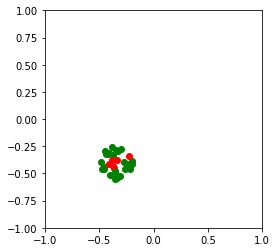

In [13]:
for model_name in model_configs.keys():
    if model_name == 'soft_param':
        labels_to_tasks = {
            "labelset:slice_1:pred": "test_task:slice_1:pred",
            "labelset:slice_2:pred": "test_task:slice_2:pred",    
            "labelset:slice_1:ind": "test_task:slice_1:ind",
            "labelset:slice_2:ind": "test_task:slice_2:ind",
        }
    else:
        labels_to_tasks = {
            "labelset:slice_1:pred": "test_task:slice_1:pred",
            "labelset:slice_2:pred": "test_task:slice_2:pred",        
        }

    eval_payload.remap_labelsets(labels_to_tasks)
    if model_name in ["hard_param", "soft_param", "manual_reweighting"]:
        print(f"{'='*10}Evaluating {model_name}{'='*10}")
        score_and_visualize(trained_models[model_name], eval_payload)

### Evaluate model on primary task head

labelset 'labelset_gold' -> task 'test_task' (originally, None).
labelset 'labelset:slice_1:pred' -> task 'test_task' (originally, test_task:slice_1:pred).
labelset 'labelset:slice_2:pred' -> task 'test_task' (originally, test_task:slice_2:pred).
labelset 'labelset:remainder:pred' -> task 'test_task' (originally, None).
==========Evaluating soft_param==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/accuracy': 0.987331081081081,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.8823529411764706,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.75,
    'test_task/payload_test/labelset_gold/accuracy': 0.9784}
Vizualizing test_task predictions on labelset_gol

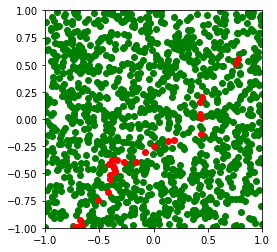

Vizualizing test_task predictions on labelset:slice_1:pred


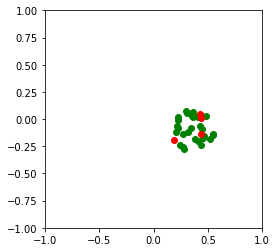

Vizualizing test_task predictions on labelset:slice_2:pred


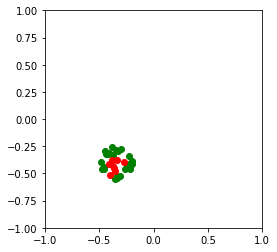

Vizualizing test_task predictions on labelset:remainder:pred


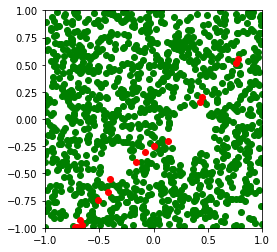

==========Evaluating soft_param_rep==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/accuracy': 0.981418918918919,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.8529411764705882,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.78125,
    'test_task/payload_test/labelset_gold/accuracy': 0.9728}
Vizualizing test_task predictions on labelset_gold


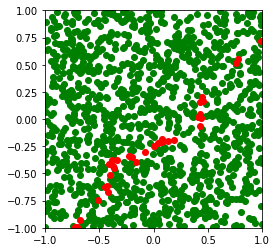

Vizualizing test_task predictions on labelset:slice_1:pred


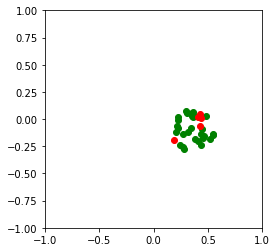

Vizualizing test_task predictions on labelset:slice_2:pred


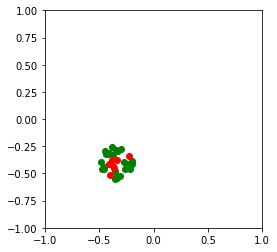

Vizualizing test_task predictions on labelset:remainder:pred


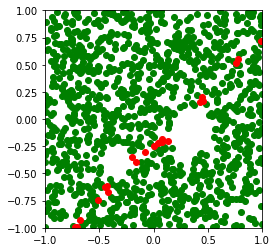

==========Evaluating hard_param==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9907094594594594,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.5294117647058824,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.53125,
    'test_task/payload_test/labelset_gold/accuracy': 0.9664}
Vizualizing test_task predictions on labelset_gold


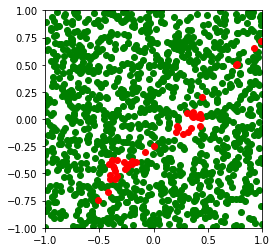

Vizualizing test_task predictions on labelset:slice_1:pred


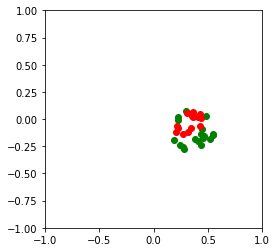

Vizualizing test_task predictions on labelset:slice_2:pred


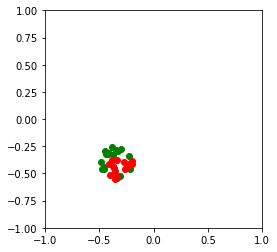

Vizualizing test_task predictions on labelset:remainder:pred


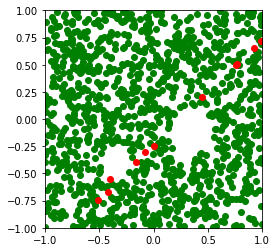

==========Evaluating manual_reweighting==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9932432432432432,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.5294117647058824,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.46875,
    'test_task/payload_test/labelset_gold/accuracy': 0.9672}
Vizualizing test_task predictions on labelset_gold


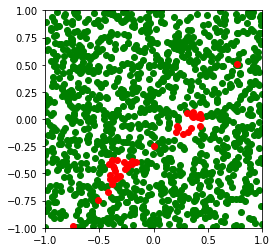

Vizualizing test_task predictions on labelset:slice_1:pred


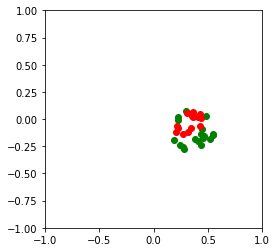

Vizualizing test_task predictions on labelset:slice_2:pred


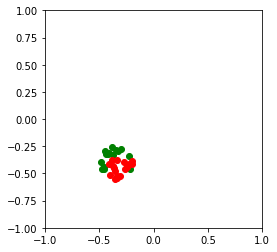

Vizualizing test_task predictions on labelset:remainder:pred


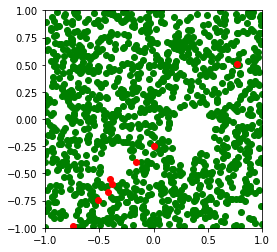

==========Evaluating moe==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9543918918918919,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.9117647058823529,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.84375,
    'test_task/payload_test/labelset_gold/accuracy': 0.9504}
Vizualizing test_task predictions on labelset_gold


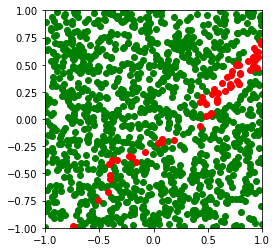

Vizualizing test_task predictions on labelset:slice_1:pred


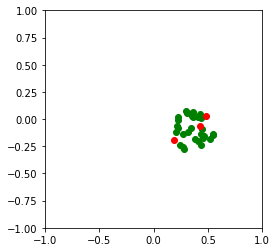

Vizualizing test_task predictions on labelset:slice_2:pred


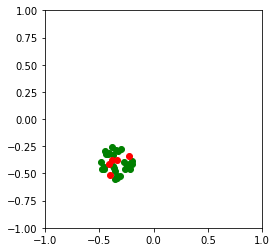

Vizualizing test_task predictions on labelset:remainder:pred


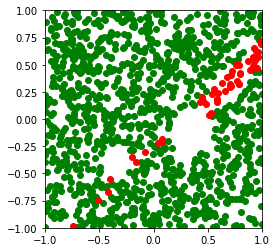

==========Evaluating naive==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9915540540540541,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.5294117647058824,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.46875,
    'test_task/payload_test/labelset_gold/accuracy': 0.9656}
Vizualizing test_task predictions on labelset_gold


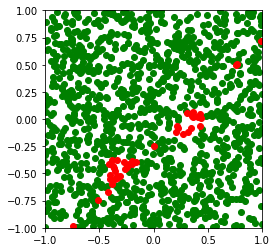

Vizualizing test_task predictions on labelset:slice_1:pred


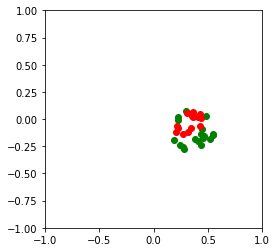

Vizualizing test_task predictions on labelset:slice_2:pred


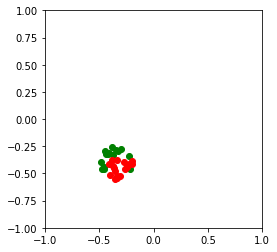

Vizualizing test_task predictions on labelset:remainder:pred


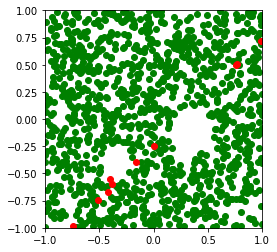

In [14]:
# map all labelsets to the primary task_head 
eval_payload.remap_labelsets(labels_to_tasks= {
        "labelset_gold": "test_task",
        "labelset:slice_1:pred": "test_task",
        "labelset:slice_2:pred": "test_task",
        "labelset:remainder:pred": "test_task"
    }
)

for model_name in model_configs.keys():
    print(f"{'='*10}Evaluating {model_name}{'='*10}")
    score_and_visualize(trained_models[model_name], eval_payload)

### Visualize Attention Weights of `soft_param`

********** soft_param **********
labelset 'labelset_gold' -> task 'None' (originally, test_task).
labelset 'labelset:slice_1:pred' -> task 'None' (originally, test_task).
labelset 'labelset:slice_1:ind' -> task 'test_task:slice_1:ind' (originally, None).
labelset 'labelset:slice_2:pred' -> task 'None' (originally, test_task).
labelset 'labelset:slice_2:ind' -> task 'test_task:slice_2:ind' (originally, None).
labelset 'labelset:remainder:pred' -> task 'None' (originally, test_task).
Vizualizing test_task:BASE:ind attention on labelset:slice_1:ind


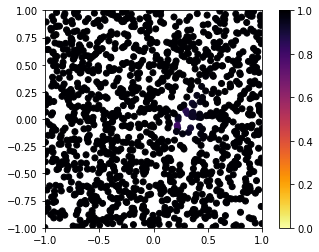

Vizualizing test_task:slice_1:ind attention on labelset:slice_1:ind


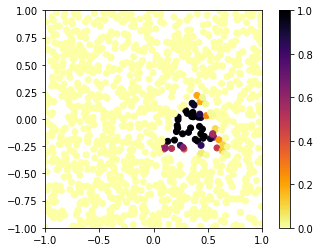

Vizualizing test_task:slice_2:ind attention on labelset:slice_1:ind


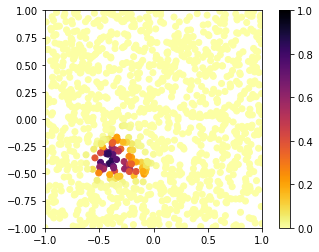

Vizualizing test_task:BASE:ind attention on labelset:slice_2:ind


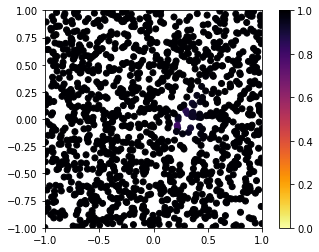

Vizualizing test_task:slice_1:ind attention on labelset:slice_2:ind


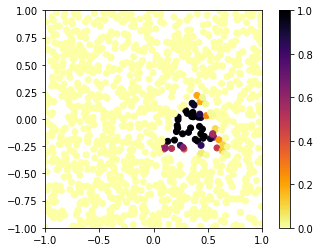

Vizualizing test_task:slice_2:ind attention on labelset:slice_2:ind


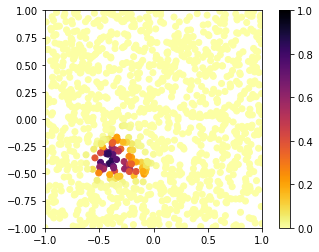

********** soft_param_rep **********
Vizualizing test_task:BASE:ind attention on labelset:slice_1:ind


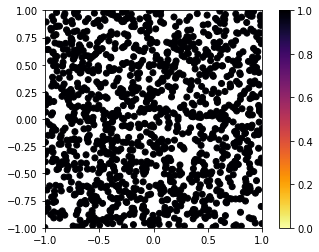

Vizualizing test_task:slice_1:ind attention on labelset:slice_1:ind


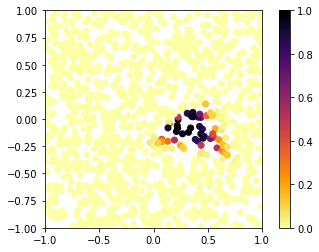

Vizualizing test_task:slice_2:ind attention on labelset:slice_1:ind


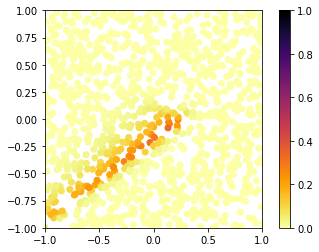

Vizualizing test_task:BASE:ind attention on labelset:slice_2:ind


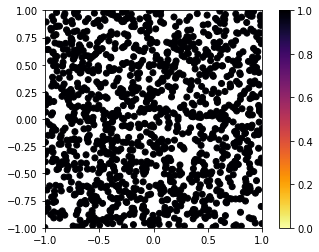

Vizualizing test_task:slice_1:ind attention on labelset:slice_2:ind


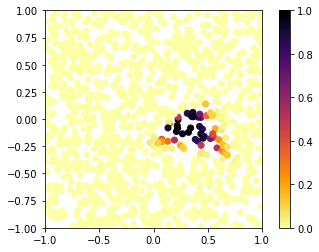

Vizualizing test_task:slice_2:ind attention on labelset:slice_2:ind


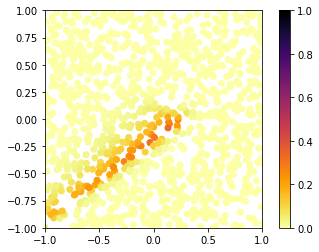

In [15]:
for model_name in trained_models.keys():
    if model_name not in ['soft_param', 'soft_param_rep']:
        continue

    print(f'{"*"*10} {model_name} {"*"*10}')
    eval_payload.remap_labelsets(labels_to_tasks = {
            "labelset:slice_1:ind": "test_task:slice_1:ind",
            "labelset:slice_2:ind": "test_task:slice_2:ind"
        }
    )

    visualize_attention(trained_models[model_name], eval_payload)